## Metrics

***Offer just started***:

- customers using offer
    - total number : DONE
    - new -  % : DONE
    - existing - % : DONE
    - vs baseline (e.g how many new customers do you get in a typical <period of time>) : DONE (used week): issue = not many weeks before offer started to compare to? 
- Frequency of the redeeming group over customer type (new vs existing, how many times do they come)
    - Overall frequency : DONE for offer period
    - vs non-redeeming group: DONE for offer period
  
- % of new customers that have purchased again: DONE
- Revenue impact
    - Total
    - per customer
    - Value of discount
        - per customer
- ATV of the redeeming group over customer type (new & existing): DONE for offer period
    - Overall ATV: DONE for offer period
    - vs non-redeeming group: DONE for offer period
***Up to here***
- Basket size
- Time of day / day of week of redemption
    - New vs existing
- redemptions on the offer (if we've seen a customer redeem more than once - otherwise assume offers are single redemption per customer)
    - new
    - existing
    - by timeframe (e.g. day, week, month depending on length of offer)
- ~~Redemptions per location? (maybe out of scope)~~

***After x time***:

- Existing customers that fall into one of segments? E.G. are they changing groups (spending more)

***Post offer analysis***:

- Long-term impact on frequency of customers redeeming the offer
    - vs non-redeemers
- Long term impact of ATV of customers redeeming the offer
    - vs non-redeemers
- Retention of customers who have redeemed the offer vs baseline
- Segment of customers acquired via the offer
    - % in each segment vs expected %
- ~~Value of the customers acquired via the offer~~
    
    
***To decide***:
- what offer period should we be looking at? If offers go on forever not sure metrics will look right
    
***Thoughts***:
    
THink some histograms by date of new and existing customers are worth including as a sanity check
I got pretty far along with analysis before realising that all enw customers were coming throuhg on the first date.
Will be useful to have included in dashboard even if just as something descirptive and easy to produce to reduce risk. 

In [1]:
# install required packages
import pandas as pd
import numpy as np
from utils.database import query_from_file
import datetime
import time
import plotly.express as px
import psutil
from datetime import datetime, timedelta

path = '/Users/jennamiles/Documents/credentials'

/Users/jennamiles/.pyenv/versions/3.9.1/lib/python3.9/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
#this is from database.py
#need to update in utils because of directory issue
import os
from psycopg2 import connect
from pandas import read_sql

def query(sql_statement: str, **kwargs):
    with open(f'{path}', 'r') as credentials:
        connection = connect(credentials.read())
        cursor = connection.cursor()

        if len(kwargs) > 0:
            dataframe = read_sql(sql_statement.format(**kwargs), connection)
        else:
            dataframe = read_sql(sql_statement, connection)

        assert len(dataframe) > 0, 'query returned no results'
        return dataframe
    
def query_from_file(sql_file: str, **kwargs):
    with open(sql_file, 'r') as f:
        return query(f.read(), **kwargs)

In [717]:
#read in pure data from SQL query:\# read in the starling transacitons 
start = time.time()
df = query_from_file('pure_txns.sql')
end = time.time()
query_time = end-start
print(f"Query took {query_time:.2f} seconds")

Query took 9.52 seconds


In [718]:
df['transaction_date'].min()

Timestamp('2018-11-22 12:19:02.324000+0000', tz='UTC')

In [719]:
#additional date columns that will be useful 
df['date'] = df['transaction_date'].dt.date
df['day'] = df['transaction_date'].dt.isocalendar().day
df['week'] = df['transaction_date'].dt.isocalendar().week
df['week_start'] = (df['transaction_date'] - pd.TimedeltaIndex(df['transaction_date'].dt.dayofweek, unit='D')).dt.date
df['month'] = df['transaction_date'].dt.month

In [720]:
#other amendments needed = price is not numeric currently 
df['price'] = pd.to_numeric(df['item_price'])

In [721]:
#make a receipt count on all Pure transactions so we can tell if the offer txn was first with retailer
#warning: only can tell if first using flux 
df_receipts = df[['customer_id','receipt_id','total_amount','transaction_date','date','month','week','location_id']].drop_duplicates().sort_values(['customer_id','transaction_date'])
df_receipts['count'] = df_receipts.groupby(['customer_id'])['receipt_id'].cumcount()+1

In [722]:
#offer transactions = where money taken off receipt
offer_txns = df[df['price']<0].copy()

In [723]:
#pick an offer to use with highest volume
offer_txns.groupby(['name']).nunique().sort_values(by = 'customer_id', ascending = False)['customer_id'].head(10)

name
Reusable Cup 12oz                     530
High Protein Chilli TA                328
Reusable Cup 8oz                      286
Thai Red Chicken TA                   232
Eat Out to Help Out discount for 1    181
Free Coffee YELLOW                    157
Free Coffee                           149
Butternut Rendang TA                  129
Malay Chicken Curry TA                121
Free Coffee BLUE                       79
Name: customer_id, dtype: int64

In [724]:
df.date.min()

datetime.date(2018, 11, 22)

In [725]:
#alternative picking an offer that has a pre-period 
#min value should be in september at least
offer_txns.groupby(['name'])['date'].min().sort_values(ascending = False).head(10)

name
Eat Out to Help Out discount for 4    2020-08-24
Eat Out to Help Out discount for 5    2020-08-12
Eat Out to Help Out discount for 2    2020-08-03
Eat Out to Help Out discount for 3    2020-08-03
Eat Out to Help Out discount for 1    2020-08-03
NHS 50 discount                       2020-06-15
Pure Porridge promotion               2020-02-17
Free Coffee PINK                      2020-02-13
Free Coffee YELLOW                    2019-12-09
20 OFF                                2019-08-28
Name: date, dtype: object

In [726]:
#maybe NHS 50 discount?
#see how many 

### Chosen offer = Free Coffe YELLOW

In [727]:
#create df that only contains the offer transactions for chosen example offer
df_off = offer_txns[offer_txns['name'] == 'Free Coffee YELLOW'].copy()
off_receipts = df_off['receipt_id'].unique()
len(off_receipts)

307

In [728]:
#apply customer segmentation to receipts
#---> were the customers newly acquired during the period? were they newly acquired on the offer?
import datetime as dt
#start offer = date_min
date_min = df_off['date'].min()

#Defining the max date to set the measurement perios - might not always want to look at the whoel period
#OPTION 1: 
#use max transaction on offer as end day 
date_max = df_off['date'].max()
d = (df_off.date.max() - df_off.date.min()).days
d_months = round(d/30)

#OPTION 2: Setting a number of days after offer start rather than end :
#d = 90
#date_max = date_min + dt.timedelta(days=d)

print(f'The offer period started on {date_min} and ended on {date_max}, lasting {d} days (or {d_months} months)')

#receipts during the offer period being considered
df_during = df_receipts[(df_receipts['date']>= date_min) & (df_receipts['date'] <= date_max)].copy()

#new customers are those that had their first receipt at Pure during the offer period 
new_customers = df_during[df_during['count']== 1].customer_id.unique()
#offer customers are those that used the offer 
offer_customers = df_off['customer_id'].unique()
#offer acquisitions = customers acquired onto the offer - made their first transaction on the offer
offer_acquisitions = df_during[(df_during['count']==1)&(df_during['receipt_id'].isin(off_receipts))]['customer_id'].unique()

df_during['new_segment'] = np.where(df_during['customer_id'].isin(new_customers),'new','existing')
df_during['offer_segment'] = np.where(df_during['customer_id'].isin(offer_customers),'redeemer','non-redeemer')
df_during['new_segment'] = np.where(df_during['customer_id'].isin(offer_acquisitions),'acquired',df_during['new_segment'])

The offer period started on 2019-12-09 and ended on 2020-11-04, lasting 331 days (or 11 months)


In [729]:
df_receipts.customer_id.nunique()

13867

In [732]:
df_during.customer_id.nunique()

7075

In [736]:
df_during.receipt_id.nunique()

22195

In [735]:
len(df_during)

22195

In [740]:
df_during.head()

,customer_id,receipt_id,total_amount,transaction_date,date,month,week,location_id,count,new_segment,offer_segment
85727,0016aba1-f401-49f5-bc44-8a19bdf0b4e0,a655a228-5a1e-49b9-8897-5f53bc4241af,315.0,2020-01-22 06:27:28+00:00,2020-01-22,1,4,9aada63a-130d-4d37-839a-bfd644eac5d5,1,new,non-redeemer
121799,0016aba1-f401-49f5-bc44-8a19bdf0b4e0,eaace13f-956b-4df9-94d5-6adffcc74d2f,215.0,2020-02-05 07:35:39+00:00,2020-02-05,2,6,9aada63a-130d-4d37-839a-bfd644eac5d5,2,new,non-redeemer
126379,002fdc46-8516-4bd0-bd5a-3cf46a9b2034,f372b9bc-3ba2-403b-b086-d023846b3e6e,150.0,2019-12-10 07:35:34+00:00,2019-12-10,12,50,9aada63a-130d-4d37-839a-bfd644eac5d5,7,existing,non-redeemer
116026,002fdc46-8516-4bd0-bd5a-3cf46a9b2034,dfd9f359-c545-4ba7-9be0-070425ae294d,170.0,2020-01-10 07:24:29+00:00,2020-01-10,1,2,9aada63a-130d-4d37-839a-bfd644eac5d5,8,existing,non-redeemer
58397,002fdc46-8516-4bd0-bd5a-3cf46a9b2034,71eced48-c597-4234-8ecb-c768dcf4af54,500.0,2020-01-18 08:53:29+00:00,2020-01-18,1,3,9aada63a-130d-4d37-839a-bfd644eac5d5,9,existing,non-redeemer


In [742]:
#a
len(df_during[df_during['customer_id']=='002fdc46-8516-4bd0-bd5a-3cf46a9b2034'])

39

In [744]:
df_during[df_during['customer_id']=='002fdc46-8516-4bd0-bd5a-3cf46a9b2034'].sort_values(['transaction_date'])

,customer_id,receipt_id,total_amount,transaction_date,date,month,week,location_id,count,new_segment,offer_segment
126379,002fdc46-8516-4bd0-bd5a-3cf46a9b2034,f372b9bc-3ba2-403b-b086-d023846b3e6e,150.0,2019-12-10 07:35:34+00:00,2019-12-10,12,50,9aada63a-130d-4d37-839a-bfd644eac5d5,7,existing,non-redeemer
116026,002fdc46-8516-4bd0-bd5a-3cf46a9b2034,dfd9f359-c545-4ba7-9be0-070425ae294d,170.0,2020-01-10 07:24:29+00:00,2020-01-10,1,2,9aada63a-130d-4d37-839a-bfd644eac5d5,8,existing,non-redeemer
58397,002fdc46-8516-4bd0-bd5a-3cf46a9b2034,71eced48-c597-4234-8ecb-c768dcf4af54,500.0,2020-01-18 08:53:29+00:00,2020-01-18,1,3,9aada63a-130d-4d37-839a-bfd644eac5d5,9,existing,non-redeemer
21427,002fdc46-8516-4bd0-bd5a-3cf46a9b2034,296579f8-5472-4b58-a3b5-5626727d8c21,300.0,2020-03-12 07:34:57+00:00,2020-03-12,3,11,9aada63a-130d-4d37-839a-bfd644eac5d5,10,existing,non-redeemer
64191,002fdc46-8516-4bd0-bd5a-3cf46a9b2034,7d5051f2-d0d0-440a-a704-de8576a13758,300.0,2020-03-14 07:06:27+00:00,2020-03-14,3,11,9aada63a-130d-4d37-839a-bfd644eac5d5,11,existing,non-redeemer
7490,002fdc46-8516-4bd0-bd5a-3cf46a9b2034,0e7f0244-8f6e-46df-9c8d-0ff3a810232d,300.0,2020-07-14 06:08:35+00:00,2020-07-14,7,29,9aada63a-130d-4d37-839a-bfd644eac5d5,12,existing,non-redeemer
95056,002fdc46-8516-4bd0-bd5a-3cf46a9b2034,b7e4f73e-1cfe-4d01-9bfa-a568db24210a,300.0,2020-07-15 06:07:09+00:00,2020-07-15,7,29,9aada63a-130d-4d37-839a-bfd644eac5d5,13,existing,non-redeemer
130182,002fdc46-8516-4bd0-bd5a-3cf46a9b2034,fafc8514-ee07-4caf-a6c5-a9836e77e3df,300.0,2020-07-16 05:51:27+00:00,2020-07-16,7,29,9aada63a-130d-4d37-839a-bfd644eac5d5,14,existing,non-redeemer
33155,002fdc46-8516-4bd0-bd5a-3cf46a9b2034,40c1c785-1b37-4c16-91f9-b296f96a8a5d,300.0,2020-07-17 05:50:59+00:00,2020-07-17,7,29,9aada63a-130d-4d37-839a-bfd644eac5d5,15,existing,non-redeemer
18426,002fdc46-8516-4bd0-bd5a-3cf46a9b2034,23c98b23-03c7-477c-82b7-9105c8fc7aef,320.0,2020-07-20 06:07:53+00:00,2020-07-20,7,30,9aada63a-130d-4d37-839a-bfd644eac5d5,16,existing,non-redeemer


In [731]:
customer_receipt_counts = df_during.groupby(['offer_segment','new_segment']).nunique()[['customer_id','receipt_id']]
customer_receipt_counts.columns = ['unique customers','unique receipts']
customer_receipt_counts

unique customers  unique receipts
offer_segment new_segment                                   
non-redeemer  existing                 3119            13857
              new                      3799             6609
redeemer      acquired                   22               54
              existing                   91             1202
              new                        44              473

In [408]:
customer_pcent = (customer_receipt_counts.loc['redeemer']['unique customers']/(customer_receipt_counts.loc['redeemer']['unique customers'].sum()))*100
print('The % split of redeemers by customer segment is:')
print(customer_pcent)

The % split of redeemers by customer segment is:
new_segment
acquired    14.012739
existing    57.961783
new         28.025478
Name: unique customers, dtype: float64


In [424]:
#work out new customer baseline
df_pre = df_receipts[df_receipts.date < date_min].copy()
baseline_pre = df_pre[df_pre['count']==1].groupby(['week','count']).nunique()[['customer_id']]/df_pre.groupby('week').nunique()[['customer_id']].tail(4)
baseline_new_pcent = baseline_pre['customer_id'].mean()*100

In [416]:
df_pre[df_pre['count']==1].groupby(['week','count']).nunique()[['customer_id']].mean()*0.0875

customer_id    16.705769
dtype: float64

In [425]:
baseline_new_pcent

51.687987623150875

In [431]:
total_cust

157

In [749]:
#adding in here basket size that will be useful 
#count the paid for items on each receipt
receipt_item_count = pd.DataFrame(df[df['price']>0].groupby('receipt_id').count()['item_id']).reset_index()
receipt_item_count.columns = ['receipt_id','basket_size']

#adding in the total amount redeemed on offer per customer and total items redeemed per customer
#these need to be excluded from value calculations 
receipt_redemption_count = pd.DataFrame(df_off.groupby('receipt_id').count()['item_id']).reset_index()
receipt_redemption_count.columns = ['receipt_id','redemption_count']

df_off['positive_price'] = df_off['price']*-1
receipt_redemption_amount = pd.DataFrame(df_off.groupby('receipt_id').sum()['positive_price']).reset_index()
receipt_redemption_amount.columns = ['receipt_id','redemption_amount']

#attach onto receipts in df_during
df_during = pd.merge(df_during,receipt_item_count, on = 'receipt_id',how = 'left')
df_during = pd.merge(df_during,receipt_redemption_count, on = 'receipt_id',how = 'left')
df_during = pd.merge(df_during,receipt_redemption_amount, on = 'receipt_id',how = 'left')
#we only want to adjsut the basket size for the receipts that customers used the offer within
df_during['adjusted_basket_size'] = np.where(df_during['receipt_id'].isin(off_receipts),(df_during['basket_size'] - df_during['redemption_count']),df_during['basket_size'])

df_during.fillna(0, inplace = True)

In [443]:
#check looks as expected
df_during[(df_during.new_segment =='acquired')].head(3)

,customer_id,receipt_id,total_amount,transaction_date,date,month,week,location_id,count,new_segment,offer_segment,basket_size,redemption_count,redemption_amount,adjusted_basket_size
2643,1e2e2630-1623-4d72-8ec1-2561d872cebb,51660799-c1f3-42ee-acc3-892a205739a0,170.0,2020-09-26 08:08:24+00:00,2020-09-26,9,39,9aada63a-130d-4d37-839a-bfd644eac5d5,1,acquired,redeemer,2.0,1.0,299.0,1.0
3022,2354a1ca-7c51-4122-9500-e4bf969e2f38,03156f0c-ee72-4ea4-88a1-7b336d21177d,125.0,2020-01-16 07:54:38+00:00,2020-01-16,1,3,9aada63a-130d-4d37-839a-bfd644eac5d5,1,acquired,redeemer,2.0,1.0,249.0,1.0
3023,2354a1ca-7c51-4122-9500-e4bf969e2f38,e3c2035a-a70c-402c-aaba-1393ea36a90f,330.0,2020-01-16 10:40:32+00:00,2020-01-16,1,3,1190fc2f-bde5-4fc7-8b07-73ff31115a77,2,acquired,redeemer,2.0,1.0,249.0,1.0


In [629]:
#grab counts, ATF, ATV  and Basket Size per group 

#first group by customer
agg = df_during.groupby(['offer_segment','new_segment','customer_id']).agg({'receipt_id':['nunique']
                                                                                        ,'total_amount':['sum','mean']
                                                                                        ,'adjusted_basket_size':['mean']})
agg.columns=agg.columns.map('_'.join)
agg.columns = ['frequency','total_amount','amount','adjusted_basket_size']
agg.reset_index(inplace = True)
#then grab metrics
agg2 = agg.groupby(['offer_segment','new_segment']).agg({'customer_id'  : ['nunique']
                                                                    ,'frequency'  : ['mean','median']
                                                                    ,'total_amount': ['sum','mean','median']
                                                                    , 'amount':['mean','median']
                                                                    , 'adjusted_basket_size':['mean','median']
                                                                           })
agg2.columns=agg2.columns.map('_'.join)
agg2['weekly_ATF'] = agg2['frequency_median']/(d/7)
agg2['yearly_ATF'] = (agg2['frequency_median']/(d))*365
agg2['ATF_offer_period'] = agg2['frequency_median']
agg2['ATV'] = agg2['amount_median']/100 #using median as less sensitive to outliers
agg2['weekly_ACV'] = (agg2['total_amount_median']/(d/7))/100
agg2['ACV_offer_period'] = (agg2['total_amount_median'])/100
agg2['ABS'] = agg2['adjusted_basket_size_median']
summary_metrics = agg2[['customer_id_nunique','weekly_ATF','ATF_offer_period','ATV','weekly_ACV','ACV_offer_period','ABS','yearly_ATF']]
summary_metrics
#note haven't separated out the custoomers acquired ON the offer here
#treating new customers during offer measurement period as all new even iff not acquired on the offer
#this is easier to measure
#just need to make sure it is clesar when displaying

customer_id_nunique  weekly_ATF  ATF_offer_period  \
offer_segment new_segment                                                      
non-redeemer  existing                    3119    0.042296               2.0   
              new                         3799    0.021148               1.0   
redeemer      acquired                      22    0.031722               1.5   
              existing                      91    0.190332               9.0   
              new                           44    0.126888               6.0   

                                ATV  weekly_ACV  ACV_offer_period       ABS  \
offer_segment new_segment                                                     
non-redeemer  existing     4.950000    0.224169            10.600  1.333333   
              new          4.900000    0.127946             6.050  1.000000   
redeemer      acquired     3.581667    0.152160             7.195  1.000000   
              existing     4.444138    0.656647            31.050  1.333333   
              new          5.112905    0.691858            32.715  1.490741   

                           yearly_ATF  
offer_segment new_segment              
non-redeemer  existing       2.205438  
              new            1.102719  
redeemer      acquired       1.654079  
              existing       9.924471  
              new            6.616314

## Metrics for new customers using offer

In [452]:
#all redeemers
total_cust = agg2.loc['redeemer'].customer_id_nunique.sum()
#all new
new_cust = agg2.loc['redeemer'].loc['new'].customer_id_nunique
#all_existing
existing_cust = agg2.loc['redeemer'].loc['existing'].customer_id_nunique
#all acquisitions on offer
offer_acq = df_during[df_during.new_segment == 'acquired']['customer_id'].nunique()

ex_cust = agg2.loc['redeemer'].loc['existing'].customer_id_nunique
new_cust_pcent = (new_cust.sum()/total_cust)*100
off_acq_pcent = (offer_acq/total_cust)*100
ex_cust_pcent = (ex_cust/total_cust)*100

baseline_weeks = len(baseline_pre)

baseline_diff = new_cust_pcent - baseline_new_pcent

print(f'The total number of unique customers that used the offer = {total_cust}')
print('\n')
print(f'{new_cust_pcent:.0f}% of redeemers are new customers during the offer period')
print(f'{off_acq_pcent:.0f}% of redeemers ({offer_acq} customers) are new customers that were acquired on the offer, meaning their first transaction was using the offer')
print(f'{ex_cust_pcent:.0f}% of redeemers are existing customers')
print('\n')
print(f'The baseline % of weekly new customers is {baseline_new_pcent:.2f}% \n(This is the average % of customers that are new based on {baseline_weeks} weeks pre offer start)')
print(f'Offer redeemers have an absolute % difference of {baseline_diff:.0f}% new customers compared to the baseline')
#alternative view ---> get the % increase in new customer volume per week erather than % distribution

The total number of unique customers that used the offer = 157


28% of redeemers are new customers during the offer period
14% of redeemers (22 customers) are new customers that were acquired on the offer, meaning their first transaction was using the offer
58% of redeemers are existing customers


The baseline % of weekly new customers is 51.69% 
(This is the average % of customers that are new based on 52 weeks pre offer start)
Offer redeemers have an absolute % difference of -24% new customers compared to the baseline


## ATF

In [458]:
summary_metrics

customer_id_nunique  weekly_ATF  ATF_offer_period  \
offer_segment new_segment                                                      
non-redeemer  existing                    3119    0.042296               2.0   
              new                         3799    0.021148               1.0   
redeemer      acquired                      22    0.031722               1.5   
              existing                      91    0.190332               9.0   
              new                           44    0.126888               6.0   

                                ATV  weekly_ACV  ACV_offer_period       ABS  
offer_segment new_segment                                                    
non-redeemer  existing     4.950000    0.224169            10.600  1.333333  
              new          4.900000    0.127946             6.050  1.000000  
redeemer      acquired     3.581667    0.152160             7.195  1.000000  
              existing     4.444138    0.656647            31.050  1.333333  
              new          5.112905    0.691858            32.715  1.490741

In [462]:
f_metrics = summary_metrics['weekly_ATF']


ATF_redeemer = agg[agg['offer_segment']=='redeemer']['frequency'].median()
ATF_non_redeemer = agg[agg['offer_segment']=='non-redeemer']['frequency'].median()

ATF_redeemer_weekly = agg[agg['offer_segment']=='redeemer']['frequency'].median()/(d/7)
ATF_non_redeemer_weekly = agg[agg['offer_segment']=='non-redeemer']['frequency'].median()/(d/7)

print(f'Redeemers of the offer transacted on average {ATF_redeemer:.0f} times during the offer period')
print(f'Non-redeemers of the offer transacted on average {ATF_non_redeemer:.0f} times during the offer period')
print('\n')
print(f'Redeemers of the offer transacted on average {ATF_redeemer_weekly:.2f} times PER WEEK during the offer period')
print(f'Non-redeemers of the offer transacted on average {ATF_non_redeemer_weekly:.2f} times PER WEEK during the offer period')
print('\n')

print('More detailed breakdown of weekly ATF:')
print(f_metrics)
print('\n')

Redeemers of the offer transacted on average 6 times during the offer period
Non-redeemers of the offer transacted on average 1 times during the offer period


Redeemers of the offer transacted on average 0.13 times PER WEEK during the offer period
Non-redeemers of the offer transacted on average 0.02 times PER WEEK during the offer period


More detailed breakdown of weekly ATF:
offer_segment  new_segment
non-redeemer   existing       0.042296
               new            0.021148
redeemer       acquired       0.031722
               existing       0.190332
               new            0.126888
Name: weekly_ATF, dtype: float64




## Repeat Rate

In [464]:
#need this as a view of x many days after their first purchase
df_acq_txns = df_during[df_during.new_segment == 'acquired'][['customer_id','date','count']].copy()
df_new_not_acq = df_during[df_during.new_segment == 'new'][['customer_id','date','count']].copy()

In [465]:
df_acq_txns['lagged_date'] = df_acq_txns.groupby('customer_id')['date'].shift(1)
df_acq_txns['date_diff'] = (df_acq_txns['date'] - df_acq_txns['lagged_date']).dt.days
df_acq_txns['week_diff'] = np.ceil(df_acq_txns.date_diff/7)

In [500]:
df_new_not_acq['lagged_date'] = df_new_not_acq.groupby('customer_id')['date'].shift(1)
df_new_not_acq['date_diff'] = (df_new_not_acq['date'] - df_new_not_acq['lagged_date']).dt.days
df_new_not_acq['week_diff'] = np.ceil(df_new_not_acq.date_diff/7)

In [513]:
repeat_by_week = pd.DataFrame(df_acq_txns[df_acq_txns['count']==2].groupby('week_diff').nunique()['customer_id']).reset_index().cumsum()
repeat_by_week['pcent_of_acquisitions'] = (repeat_by_week['customer_id']/len(offer_acquisitions))*100
repeat_by_week.columns = ['weeks_since_transaction','cumulative_made_second_transaction','pcent']
repeat_by_week.set_index('weeks_since_transaction', inplace = True)
repeat_by_week

,cumulative_made_second_transaction,pcent
weeks_since_transaction,,
0.0,2,9.090909
1.0,7,31.818182
3.0,8,36.363636
6.0,9,40.909091
11.0,11,50.000000


In [514]:
#all customer new not acquired on the offer
new_count = summary_metrics.loc['non-redeemer'].loc['new']['customer_id_nunique']+ summary_metrics.loc['redeemer'].loc['new']['customer_id_nunique']

In [515]:
#look at cumulative repeat for all new customers not acquired
repeat_by_week2 = pd.DataFrame(df_new_not_acq[df_new_not_acq['count']==2].groupby('week_diff').nunique()['customer_id']).reset_index().cumsum()
repeat_by_week2['pcent_of_acquisitions'] = (repeat_by_week2['customer_id']/new_count)*100
repeat_by_week2.columns = ['weeks_since_transaction','cumulative_made_second_transaction','pcent']
repeat_by_week2.set_index('weeks_since_transaction', inplace = True)
repeat_by_week2 = repeat_by_week2.loc[:12]

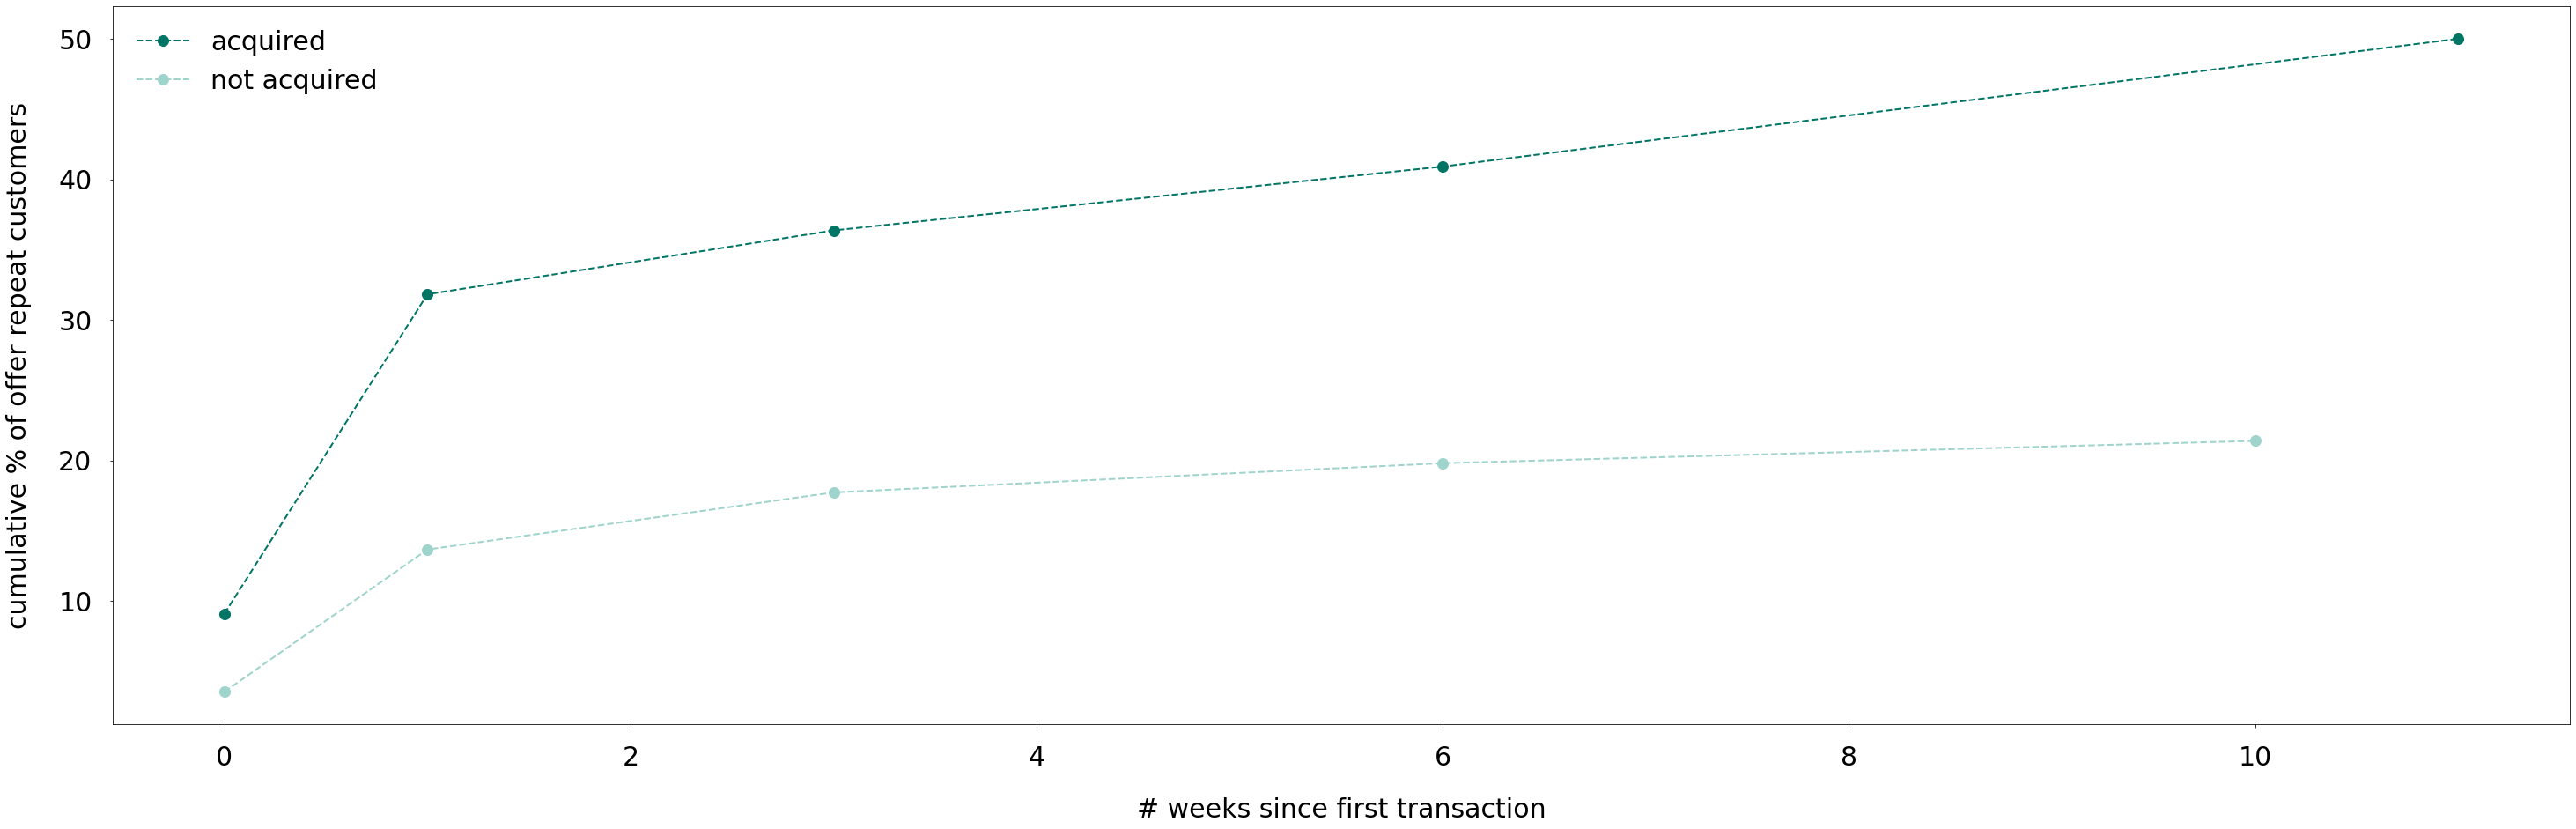

In [526]:
x1 = repeat_by_week.index.values
y1 = repeat_by_week['pcent']
x2 = repeat_by_week2.index.values
y2 = repeat_by_week2['pcent']
plt.plot(x1,y1,marker='o', linestyle='dashed',linewidth=2, markersize=12, label = 'acquired')
plt.plot(x2,y2,marker='o', linestyle='dashed',linewidth=2, markersize=12, label = 'not acquired', color = 'mint')
plt.ylabel('cumulative % of offer repeat customers', size = 30)
plt.xlabel('# weeks since first transaction', size = 30)
plt.legend(fontsize = 30)
plt.show()

In [525]:

new_8wk_repeat = repeat_by_week2.loc[:8]['pcent'].max()
acq_8wk_repeat = repeat_by_week.loc[:8]['pcent'].max()


print(f'Not acquired: 8 weeks after first transaction {new_8wk_repeat:.0f}% of customers had made a repeat purchase')
print(f'Acquired: 8 weeks after first transaction {acq_8wk_repeat:.0f}% of customers had made a repeat purchase')
print('\n')


Not acquired: 4 weeks after first transaction 18% of customers had made a repeat purchase
Acquired: 4 weeks after first transaction 36% of customers had made a repeat purchase


Not acquired: 8 weeks after first transaction 20% of customers had made a repeat purchase
Acquired: 8 weeks after first transaction 41% of customers had made a repeat purchase


Not acquired: 12 weeks after first transaction 21% of customers had made a repeat purchase
Acquired: 12 weeks after first transaction 50% of customers had made a repeat purchase


In [627]:
repeat_by_week2.loc[:8]['cumulative_made_second_transaction'].max()

761

In [620]:
purchase3= pd.DataFrame(df_acq_txns[df_acq_txns['count']==3].groupby('week_diff').nunique()['customer_id']).reset_index().cumsum()
purchase3['pcent_of_acquisitions'] = (purchase3['customer_id']/len(offer_acquisitions))*100
purchase3.columns = ['weeks_since_transaction','cumulative_made_second_transaction','pcent']
purchase3.set_index('weeks_since_transaction', inplace = True)
purchase3

#look at cumulative repeat for all new customers not acquired
purchase3b = pd.DataFrame(df_new_not_acq[df_new_not_acq['count']==3].groupby('week_diff').nunique()['customer_id']).reset_index().cumsum()
purchase3b['pcent_of_acquisitions'] = (purchase3b['customer_id']/new_count)*100
purchase3b.columns = ['weeks_since_transaction','cumulative_made_second_transaction','pcent']
purchase3b.set_index('weeks_since_transaction', inplace = True)
purchase3b = purchase3b.loc[:12]

new_8wk_repeat3 = purchase3b.loc[:8]['pcent'].max()
acq_8wk_repeat3 = purchase3.loc[:8]['pcent'].max()

print('Out of all the original customers')
print(f'Not acquired: 8 weeks after first transaction {new_8wk_repeat3:.0f}% of customers had made a repeat purchase')
print(f'Acquired: 8 weeks after first transaction {acq_8wk_repeat3:.0f}% of customers had made a repeat purchase')
print('\n')


Out of all the original customers
Not acquired: 8 weeks after first transaction 11% of customers had made a repeat purchase
Acquired: 8 weeks after first transaction 32% of customers had made a repeat purchase




In [628]:
purchase3= pd.DataFrame(df_acq_txns[df_acq_txns['count']==3].groupby('week_diff').nunique()['customer_id']).reset_index().cumsum()
purchase3['pcent_of_acquisitions'] = (purchase3['customer_id']/repeat_by_week.loc[:8]['cumulative_made_second_transaction'].max())*100
purchase3.columns = ['weeks_since_transaction','cumulative_made_second_transaction','pcent']
purchase3.set_index('weeks_since_transaction', inplace = True)
purchase3

#look at cumulative repeat for all new customers not acquired
purchase3b = pd.DataFrame(df_new_not_acq[df_new_not_acq['count']==3].groupby('week_diff').nunique()['customer_id']).reset_index().cumsum()
purchase3b['pcent_of_acquisitions'] = (purchase3b['customer_id']/repeat_by_week2.loc[:8]['cumulative_made_second_transaction'].max())*100
purchase3b.columns = ['weeks_since_transaction','cumulative_made_second_transaction','pcent']
purchase3b.set_index('weeks_since_transaction', inplace = True)
purchase3b = purchase3b.loc[:12]

new_8wk_repeat3 = purchase3b.loc[:8]['pcent'].max()
acq_8wk_repeat3 = purchase3.loc[:8]['pcent'].max()

print('Out of all the customers that made a 2nd purchase')
print(f'Not acquired: 8 weeks after first transaction {new_8wk_repeat3:.0f}% of customers had made a repeat purchase')
print(f'Acquired: 8 weeks after first transaction {acq_8wk_repeat3:.0f}% of customers had made a repeat purchase')
print('\n')


Out of all the customers that made a 2nd purchase
Not acquired: 8 weeks after first transaction 55% of customers had made a repeat purchase
Acquired: 8 weeks after first transaction 78% of customers had made a repeat purchase




In [618]:
purchase4= pd.DataFrame(df_acq_txns[df_acq_txns['count']==4].groupby('week_diff').nunique()['customer_id']).reset_index().cumsum()
purchase4['pcent_of_acquisitions'] = (purchase4['customer_id']/len(offer_acquisitions))*100
purchase4.columns = ['weeks_since_transaction','cumulative_made_second_transaction','pcent']
purchase4.set_index('weeks_since_transaction', inplace = True)
purchase4

#look at cumulative repeat for all new customers not acquired
purchase4b = pd.DataFrame(df_new_not_acq[df_new_not_acq['count']==4].groupby('week_diff').nunique()['customer_id']).reset_index().cumsum()
purchase4b['pcent_of_acquisitions'] = (purchase4b['customer_id']/new_count)*100
purchase4b.columns = ['weeks_since_transaction','cumulative_made_second_transaction','pcent']
purchase4b.set_index('weeks_since_transaction', inplace = True)
purchase4b = purchase4b.loc[:12]

new_8wk_repeat4 = purchase4b.loc[:8]['pcent'].max()
acq_8wk_repeat4 = purchase4.loc[:8]['pcent'].max()

print(f'Not acquired: 8 weeks after first transaction {new_8wk_repeat4:.0f}% of customers had made a repeat purchase')
print(f'Acquired: 8 weeks after first transaction {acq_8wk_repeat4:.0f}% of customers had made a repeat purchase')
print('\n')


Not acquired: 8 weeks after first transaction 7% of customers had made a repeat purchase
Acquired: 8 weeks after first transaction 14% of customers had made a repeat purchase




In [619]:
purchase4= pd.DataFrame(df_acq_txns[df_acq_txns['count']==5].groupby('week_diff').nunique()['customer_id']).reset_index().cumsum()
purchase4['pcent_of_acquisitions'] = (purchase4['customer_id']/len(offer_acquisitions))*100
purchase4.columns = ['weeks_since_transaction','cumulative_made_second_transaction','pcent']
purchase4.set_index('weeks_since_transaction', inplace = True)
purchase4

#look at cumulative repeat for all new customers not acquired
purchase4b = pd.DataFrame(df_new_not_acq[df_new_not_acq['count']==5].groupby('week_diff').nunique()['customer_id']).reset_index().cumsum()
purchase4b['pcent_of_acquisitions'] = (purchase4b['customer_id']/new_count)*100
purchase4b.columns = ['weeks_since_transaction','cumulative_made_second_transaction','pcent']
purchase4b.set_index('weeks_since_transaction', inplace = True)
purchase4b = purchase4b.loc[:12]

new_8wk_repeat4 = purchase4b.loc[:8]['pcent'].max()
acq_8wk_repeat4 = purchase4.loc[:8]['pcent'].max()

print(f'Not acquired: 8 weeks after first transaction {new_8wk_repeat4:.0f}% of customers had made a repeat purchase')
print(f'Acquired: 8 weeks after first transaction {acq_8wk_repeat4:.0f}% of customers had made a repeat purchase')
print('\n')


Not acquired: 8 weeks after first transaction 5% of customers had made a repeat purchase
Acquired: 8 weeks after first transaction 9% of customers had made a repeat purchase




## Revenue Impact (during offer peri
- Total
- per customer
- Value of discount
    - per customer

### Existing customers

In [668]:
#existing incremental value 
#can do this calculation at average or total level

#during offer period
during_spend = agg[agg['new_segment']=='existing'].groupby('offer_segment').agg({'total_amount':['mean','median','sum']})

#pre offer period
#first need to know the redemption segments they ended up in 
offer_period_segs = agg[['customer_id','offer_segment']].drop_duplicates()
#by definition all customers in the pre offer period are in the existing segment but will need to attach on redemption segment to pre transactions
pre_offer_transactions = df[df['date']<date_min][['customer_id','receipt_id','total_amount','date','updated_date']].drop_duplicates()
pre_offer_seg = pd.merge(pre_offer_transactions,offer_period_segs, on = 'customer_id',how = 'left')
pre_offer_seg.fillna(0, inplace = True)
pre_spend = pre_offer_seg.groupby('offer_segment').agg({'total_amount':['mean','median','sum']})
#need to be carefull here with null values -> where customers do not transact in offer period 
#and with what type of average being used
print(pre_spend)
print(during_spend)

#divide by the number of days the offer period was live and the number of days of pre period to make comparable
pre_days = (df_during.date.min() - pre_offer_transactions.date.min()).days
during_days = (df_during.date.max() - df_during.date.min()).days

print('\n')
print(f'The number of days in the pre period is {pre_days}')
print(f'The number of days in the offer period is {during_days}')
print('\n')
print('Total amount per days pre:')
pre_spend_daily = pre_spend/pre_days
print(pre_spend_daily)
print('\n')
print('Total amount per days offer:')
during_spend_daily = during_spend/during_days
print(during_spend_daily)

              total_amount                   
                      mean median         sum
offer_segment                                
0               514.688424  485.0   8981313.0
non-redeemer    512.450337  485.0  14590486.0
redeemer        474.567586  385.0    705682.0
              total_amount                   
                      mean  median        sum
offer_segment                                
non-redeemer   2271.809875  1060.0  7085775.0
redeemer       6202.197802  3105.0   564400.0


The number of days in the pre period is 382
The number of days in the offer period is 331


Total amount per days pre:
              total_amount                        
                      mean    median           sum
offer_segment                                     
0                 1.347352  1.269634  23511.290576
non-redeemer      1.341493  1.269634  38194.989529
redeemer          1.242324  1.007853   1847.335079


Total amount per days offer:
              total_amount          

In [680]:
#calculate change in spend for redeemers and non-redeemers
redeemer_change = during_spend_daily['total_amount']['median']['redeemer'] - pre_spend_daily['total_amount']['median']['redeemer']
pcent_redeemer_change = redeemer_change/(pre_spend_daily['total_amount']['median']['redeemer'])

non_redeemer_change = during_spend_daily['total_amount']['median']['non-redeemer'] - pre_spend_daily['total_amount']['median']['non-redeemer']
pcent_non_redeemer_change = non_redeemer_change/(pre_spend_daily['total_amount']['median']['non-redeemer'])

if pcent_redeemer_change**2 > pcent_non_redeemer_change**2:
    larger_smaller = 'larger'
else: 
    larger_smaller = 'smaller'
    
if pcent_redeemer_change > 0:
    increase_decrease = 'increase'
else:
    increase_decrease = 'decrease'

incr_pcent = pcent_redeemer_change-pcent_non_redeemer_change
avg_pre_spend_redeemer = pre_spend_daily['total_amount']['median']['redeemer']/100
incr_spend = (avg_pre_spend_redeemer * incr_pcent)

print('Existing Customers \n')
print(f'The redeemers of the offer have a {larger_smaller} proportional {increase_decrease} in daily average spend than the non-redeemers between the pre period and offer period')
print(f'The perentage change in spend between periods is {pcent_redeemer_change*100:.0f}% in the redeemer group & {pcent_non_redeemer_change*100:.0f}% in the non-redeemer group')
print(f'Incremental accounts for {incr_pcent*100:.0f}% of spend in the redeemer group')
print(f'The average pre spend per redeemer per day was £{avg_pre_spend_redeemer:.2f}, resulting in a daily incremental spend per redeemer of £{incr_spend:.2f}')
#incr_spend_total = incr_spend*total_cust*(during_days/pre_days)
incr_spend_total = incr_spend*total_cust*30
print(f'Over the offer measurement period of {30} days, this is a total incremental spend of £{incr_spend_total:.0f} across the {existing_cust} customers')
print(f'Or £{(incr_spend_total/existing_cust):.2f} per customer')

Existing Customers 

The redeemers of the offer have a larger proportional increase in daily average spend than the non-redeemers between the pre period and offer period
The perentage change in spend between periods is 831% in the redeemer group & 152% in the non-redeemer group
Incremental accounts for 679% of spend in the redeemer group
The average pre spend per redeemer per day was £0.01, resulting in a daily incremental spend per redeemer of £0.07
Over the offer measurement period of 30 days, this is a total incremental spend of £322 across the 91.0 customers
Or £3.54 per customer


In [670]:
from utils import style
import matplotlib
matplotlib.rcParams['font.sans-serif'] = 'Akkurat Pro'
matplotlib.rcParams['font.serif'] = 'Vesterbro'
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.size'] = '15'

matplotlib.rcParams['figure.figsize'] = (50, 15)
matplotlib.rcParams['figure.titlesize'] = '25'

matplotlib.rcParams['axes.titlesize'] = '25'
matplotlib.rcParams['axes.labelsize'] = '15'
matplotlib.rcParams['axes.titlepad'] = '25'
matplotlib.rcParams['axes.labelpad'] = '30'
matplotlib.rcParams['xtick.labelsize'] = '15'
matplotlib.rcParams['ytick.labelsize'] = '20'

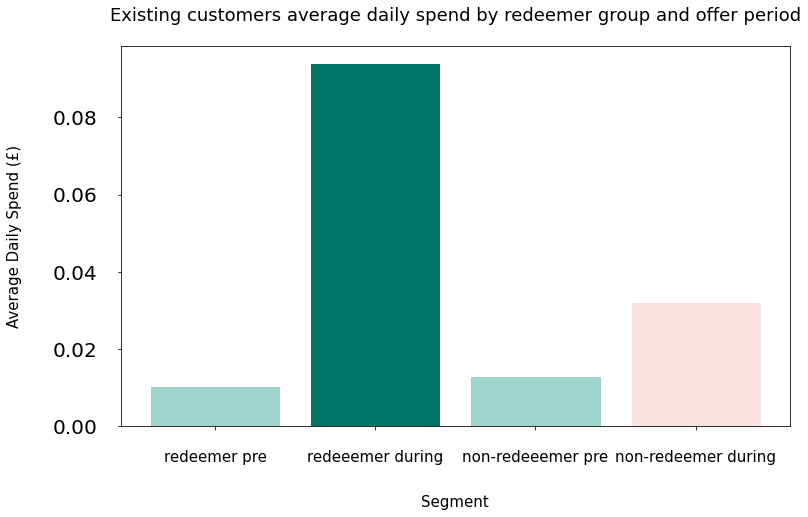

In [671]:
#quick plot of difference to help understanding
import matplotlib.pyplot as plt
plt.figure(figsize = (12,7))
rp = pre_spend_daily['total_amount']['median']['redeemer']/100
rd = during_spend_daily['total_amount']['median']['redeemer']/100
nrp = pre_spend_daily['total_amount']['median']['non-redeemer']/100
nrd = during_spend_daily['total_amount']['median']['non-redeemer']/100
x = ['redeemer pre','redeeemer during','non-redeeemer pre','non-redeemer during']
y = pd.Series([rp,rd,nrp,nrd])

chart = plt.bar(x,y)
chart[0].set_color('mint')
chart[1].set_color('green')
chart[2].set_color('mint')
chart[3].set_color('pink')
plt.title('Existing customers average daily spend by redeemer group and offer period', size = 18)
plt.ylabel('Average Daily Spend (£)', size = 15)
plt.xlabel('Segment', size = 15)

plt.show()

In [112]:
#Is the difference significant?

In [113]:
#should we be only looking at the spend after taking out the offer or for the wohle offer period?
#---> i think this is OK because if the offer was at the end, it woul dhave less time to take effect so have a smaller impact on result?
# but what id there was another offer than increased spend?
# ---> the non-redeeming frgroup could have also taken out this offer. 
#if after the offer, makes it more difficult to do redeemer/non-redeemer compariso

### New customers

In [528]:
#want to find out the average number of days each new customer was active for in the measurement period
new_cust_first_txn = df_during[(df_during.new_segment=='new')&(df_during['count']==1)][['customer_id','date','offer_segment']].copy()
#work uot at what point in the measurement period, the new customer joined and began transacting 
new_cust_first_txn['days_active'] = (date_max - new_cust_first_txn['date']).astype('timedelta64[D]')
#what is the average active days for new customers in each redemption group 
new_days_active = new_cust_first_txn.groupby('offer_segment').agg({'days_active':['mean','median']})

In [681]:
#new customers spend 

#during offer period
during_spend_new = agg[agg['new_segment']=='new'].groupby('offer_segment').agg({'total_amount':['mean','median','sum']})
daily_avg_spend_new = during_spend_new['total_amount']['median']/new_days_active['days_active']['median']
daily_incr_new = (daily_avg_spend_new['redeemer'] - daily_avg_spend_new['non-redeemer'])/100
incr_spend_new = daily_incr_new*new_cust*30

print(f'For new customers, daily average incremetal spend was £{daily_incr_new:.2f} in the redeemer group')
print(f'')
print(f'Over the offer measurement period of {30} days, this is a total incremental spend of £{incr_spend_new:.2f} across the {new_cust:.0f} customers')
print(f'Or £{incr_spend_new/new_cust:.2f} per customer')

For new customers, daily average incremetal spend was £0.40 in the redeemer group

Over the offer measurement period of 30 days, this is a total incremental spend of £522.20 across the 44 customers
Or £11.87 per customer


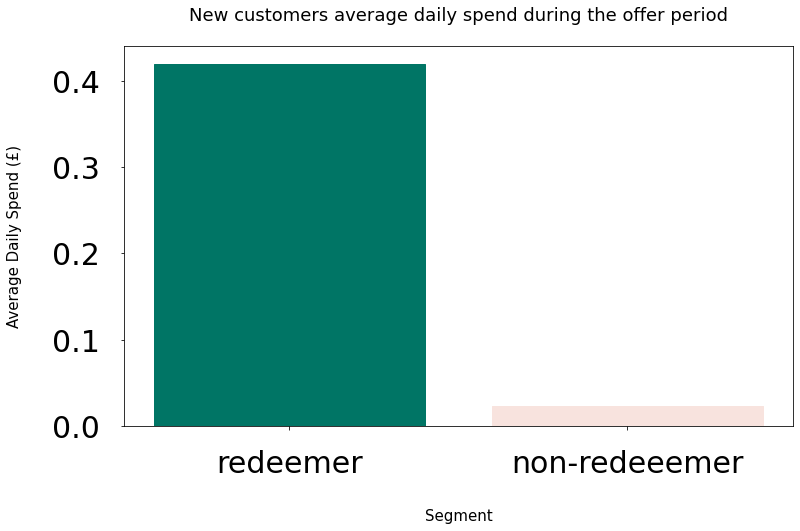

In [530]:
#quick plot of difference to help understanding

plt.figure(figsize = (12,7))
rd = daily_avg_spend_new['redeemer']/100
nrd = daily_avg_spend_new['non-redeemer']/100
x = ['redeemer','non-redeeemer']
y = pd.Series([rd,nrd])

chart = plt.bar(x,y)
chart[0].set_color('green')
chart[1].set_color('pink')
plt.title('New customers average daily spend during the offer period', size = 18)
plt.ylabel('Average Daily Spend (£)', size = 15)
plt.xlabel('Segment', size = 15)

plt.show()

## Acquired customers

In [ ]:
df_acq_txns['lagged_date'] = df_acq_txns.groupby('customer_id')['date'].shift(1)
df_acq_txns['date_diff'] = (df_acq_txns['date'] - df_acq_txns['lagged_date']).dt.days
df_acq_txns['week_diff'] = np.ceil(df_acq_txns.date_diff/7)

In [659]:
acq = agg[agg['new_segment']=='acquired']
first_date = pd.DataFrame(df_during[df_during['new_segment']=='acquired'].groupby('customer_id').date.min())
new_df = pd.merge(acq,first_date, on = 'customer_id', how = 'left')
new_df['max_date'] = date_max
new_df['date_diff'] = (new_df.max_date - new_df.date).dt.days
roi_monthly_total = ((new_df['total_amount']/new_df['date_diff'])*30).sum()
roi_monthly_avg = ((new_df['total_amount']/new_df['date_diff'])*30).mean()

print(roi_monthly_total)
print(roi_monthly_avg)

#need the number of days they were active = max-date - first_transaction_date
#calcaulte total monthly spend 
#monthly spend = ROI contribution

4738.264382485578
215.37565374934445


In [541]:
agg[agg['new_segment']=='acquired'].nunique()['customer_id']

22

In [543]:
agg[agg['new_segment']=='acquired']['total_amount'].sum()

22044.0

In [549]:
during_spend_acquired = agg[agg['new_segment']=='acquired']['total_amount'].sum()
acquired_cust = agg[agg['new_segment']=='acquired'].nunique()['customer_id']

print(f'For aquired customers, all spend is attributed to the offer')
print(f'Assumption is that the offer drove them to start transacting with the retailer')
print('\n')
print(f'Over the offer measurement period of {during_days} days, this is a total spend of £{during_spend_acquired:.2f} across the {acquired_cust:.0f} customers')
print(f'Or £{during_spend_acquired/acquired_cust:.2f} per customer')
print(f'Or £{(during_spend_acquired/acquired_cust)/d:.2f} per customer per day')

For aquired customers, all spend is attributed to the offer
Assumption is that the offer drove them to start transacting with the retailer


Over the offer measurement period of 331 days, this is a total spend of £22044.00 across the 22 customers
Or £1002.00 per customer
Or £3.03 per customer per day


### Total Revenue

In [682]:
total_incr_rev = incr_spend_new + incr_spend_total 
total_incr_rev_cust = total_incr_rev/total_cust

print(f'The total incremental revenue from this offer over the measurement period is £{total_incr_rev:.0f}')
print(f'Per redeemer this is £{total_incr_rev_cust:.2f}')

The total incremental revenue from this offer over the measurement period is £844
Per redeemer this is £5.38


### Total Cost

In [683]:
#= sum of redeemer price 
redeemer_receipts_during = df_during[df_during.new_segment.isin(['new','existing'])]['receipt_id'].unique()

total_cost = (df_off[df_off['receipt_id'].isin(redeemer_receipts_during)]['price']*-1).sum()/100
total_cost_cust = total_cost/total_cust

print(f'The total discount given out over the offer measurement period is £{total_cost}')
print(f'Per redeemer this is £{total_cost_cust:.2f}')

The total discount given out over the offer measurement period is £779.91
Per redeemer this is £4.97


# Cost acquired only

In [661]:
#cost for acquired:


redeemer_receipts_during = df_during[df_during['new_segment'] == 'acquired']['receipt_id'].unique()

total_cost_acq = (df_off[df_off['receipt_id'].isin(redeemer_receipts_during)]['price']*-1).sum()/100
total_cost_cust_acq = total_cost/total_cust

print(f'The total discount given out over the offer measurement period is £{total_cost}')
print(f'Per redeemer this is £{total_cost_cust:.2f}')

The total discount given out over the offer measurement period is £104.39
Per redeemer this is £0.66


# ROI acquired only

In [704]:
print(f'Acquired customers monthly revenue is £{roi_monthly_total:.2f}')
print(f'Acquired customers cost is £{total_cost_acq:.2f}')

print((roi_monthly_total - total_cost_acq))

ROI_acq = (roi_monthly_total/total_cost_acq)
print(f'Return on investment is {ROI_acq:.2f}')

Acquired customers monthly revenue is £4738.26
Acquired customers cost is £104.39
4633.874382485577
Return on investment is 45.39


## ROI not acquired

In [705]:
ROI = (total_incr_rev/total_cost)


print((total_incr_rev - total_cost))

print(f'Previous customers monthly increase in revenue is £{total_incr_rev:.2f}')
print(f'Previous customers cost is £{total_cost:.2f}')
print(f'Return on investment is {ROI:.2f}')

64.38274511142606
Previous customers monthly increase in revenue is £844.29
Previous customers cost is £779.91
Return on investment is 1.08


## ATV

In [686]:
v_metrics = agg2['ATV']

agg
ATV_redeemer = agg[agg['offer_segment']=='redeemer']['amount'].median()/100
ATV_non_redeemer = agg[agg['offer_segment']=='non-redeemer']['amount'].median()/100

print(f'Redeemers have an average transaction value of £{ATV_redeemer:.2f} during the offer period')
print(f'Non-redeemers have an average transaction value of £{ATV_non_redeemer:.2f} time during the offer period')
print('\n')

print('More detailed breakdown of ATV:')
print(v_metrics)
print('\n')

Redeemers have an average transaction value of £4.45 during the offer period
Non-redeemers have an average transaction value of £4.94 time during the offer period


More detailed breakdown of ATV:
offer_segment  new_segment
non-redeemer   existing       4.950000
               new            4.900000
redeemer       acquired       3.581667
               existing       4.444138
               new            5.112905
Name: ATV, dtype: float64




In [714]:
#average transaction value of redemmers total is :
agg[agg['offer_segment']=='redeemer']['amount'].median()/100

4.452051282051283

In [688]:
agg['prev_segment']= np.where(agg['new_segment'].isin(['existing','new']),'previous','acquired')

In [691]:
agg3 = agg.groupby(['offer_segment','prev_segment']).agg({'customer_id'  : ['nunique']
                                                                    ,'frequency'  : ['mean','median']
                                                                    ,'total_amount': ['sum','mean','median']
                                                                    , 'amount':['mean','median']
                                                                    , 'adjusted_basket_size':['mean','median']
                                                                           })

In [701]:
#£ ATV for previosu vs acquired
agg3.loc['redeemer']['amount']['median']/100

prev_segment
acquired    3.581667
previous    4.523333
Name: median, dtype: float64

In [703]:
agg3.loc['redeemer']['customer_id']['nunique']/(agg3.loc['redeemer']['customer_id']['nunique'].sum())

prev_segment
acquired    0.140127
previous    0.859873
Name: nunique, dtype: float64

## Basket Size

In [563]:
#now can summarise by segments the average basket size 
b_metrics = agg2['ABS']

ABS_redeemer = agg[agg['offer_segment']=='redeemer']['adjusted_basket_size'].median()
ABS_non_redeemer = agg[agg['offer_segment']=='non-redeemer']['adjusted_basket_size'].median()

print('Excluding the item on offer from the basket:')
print(f'Redeemers have an average basket size of {ABS_redeemer:.2f} during the offer period')
print(f'Non-redeemers have an average basket size of {ABS_non_redeemer:.2f} time during the offer period')
print('\n')

print('More detailed breakdown of Basket Size:')
print(b_metrics)
print('\n')

Excluding the item on offer from the basket:
Redeemers have an average basket size of 1.33 during the offer period
Non-redeemers have an average basket size of 1.22 time during the offer period


More detailed breakdown of Basket Size:
offer_segment  new_segment
non-redeemer   existing       1.333333
               new            1.000000
redeemer       acquired       1.000000
               existing       1.333333
               new            1.490741
Name: ABS, dtype: float64




## Time of Day/ Day of Week Redemption

In [751]:
df_during['weekday_name'] = df_during['transaction_date'].dt.day_name()
df_during['weekday'] = df_during['transaction_date'].dt.weekday
df_during['time_hour'] = df_during['transaction_date'].dt.hour

In [752]:
days = pd.DataFrame(df_during[df_during['redemption_count']>0].groupby(['weekday','weekday_name']).nunique()['receipt_id'])
days.columns = ['unique_receipts']
days.reset_index('weekday', drop = True, inplace = True)
top_day = days.sort_values(by = 'unique_receipts',ascending = False).head(1)
print(f'Overall, the most popular day to redeem is {top_day.index.values[0]}')

Overall, the most popular day to redeem is Tuesday


In [756]:
days

,unique_receipts
weekday_name,
Monday,52
Tuesday,68
Wednesday,62
Thursday,58
Friday,58
Saturday,7
Sunday,2


In [771]:
#split by new and existing redeemers
days_seg = pd.DataFrame(df_during[df_during['redemption_count']>0].groupby(['new_segment','weekday','weekday_name']).nunique()['receipt_id']).reset_index()
days_seg['new_segment']=days_seg['new_segment'].replace('new','existing')
days_seg = days_seg.groupby(['new_segment','weekday','weekday_name']).sum()
days_seg.columns = ['unique_receipts']
days_seg.reset_index('weekday', drop = True, inplace = True)
top_day_existing = days_seg.loc['existing'].sort_values(by = 'unique_receipts',ascending = False).head(1).index.values[0]
top_day_acquired = days_seg.loc['acquired'].sort_values(by = 'unique_receipts',ascending = False).head(1).index.values[0]
print(f'The most popular day for existing customers is {top_day_existing}')
print(f'The most popular day for acquired customers is {top_day_acquired}')

The most popular day for existing customers is Wednesday
The most popular day for acquired customers is Thursday


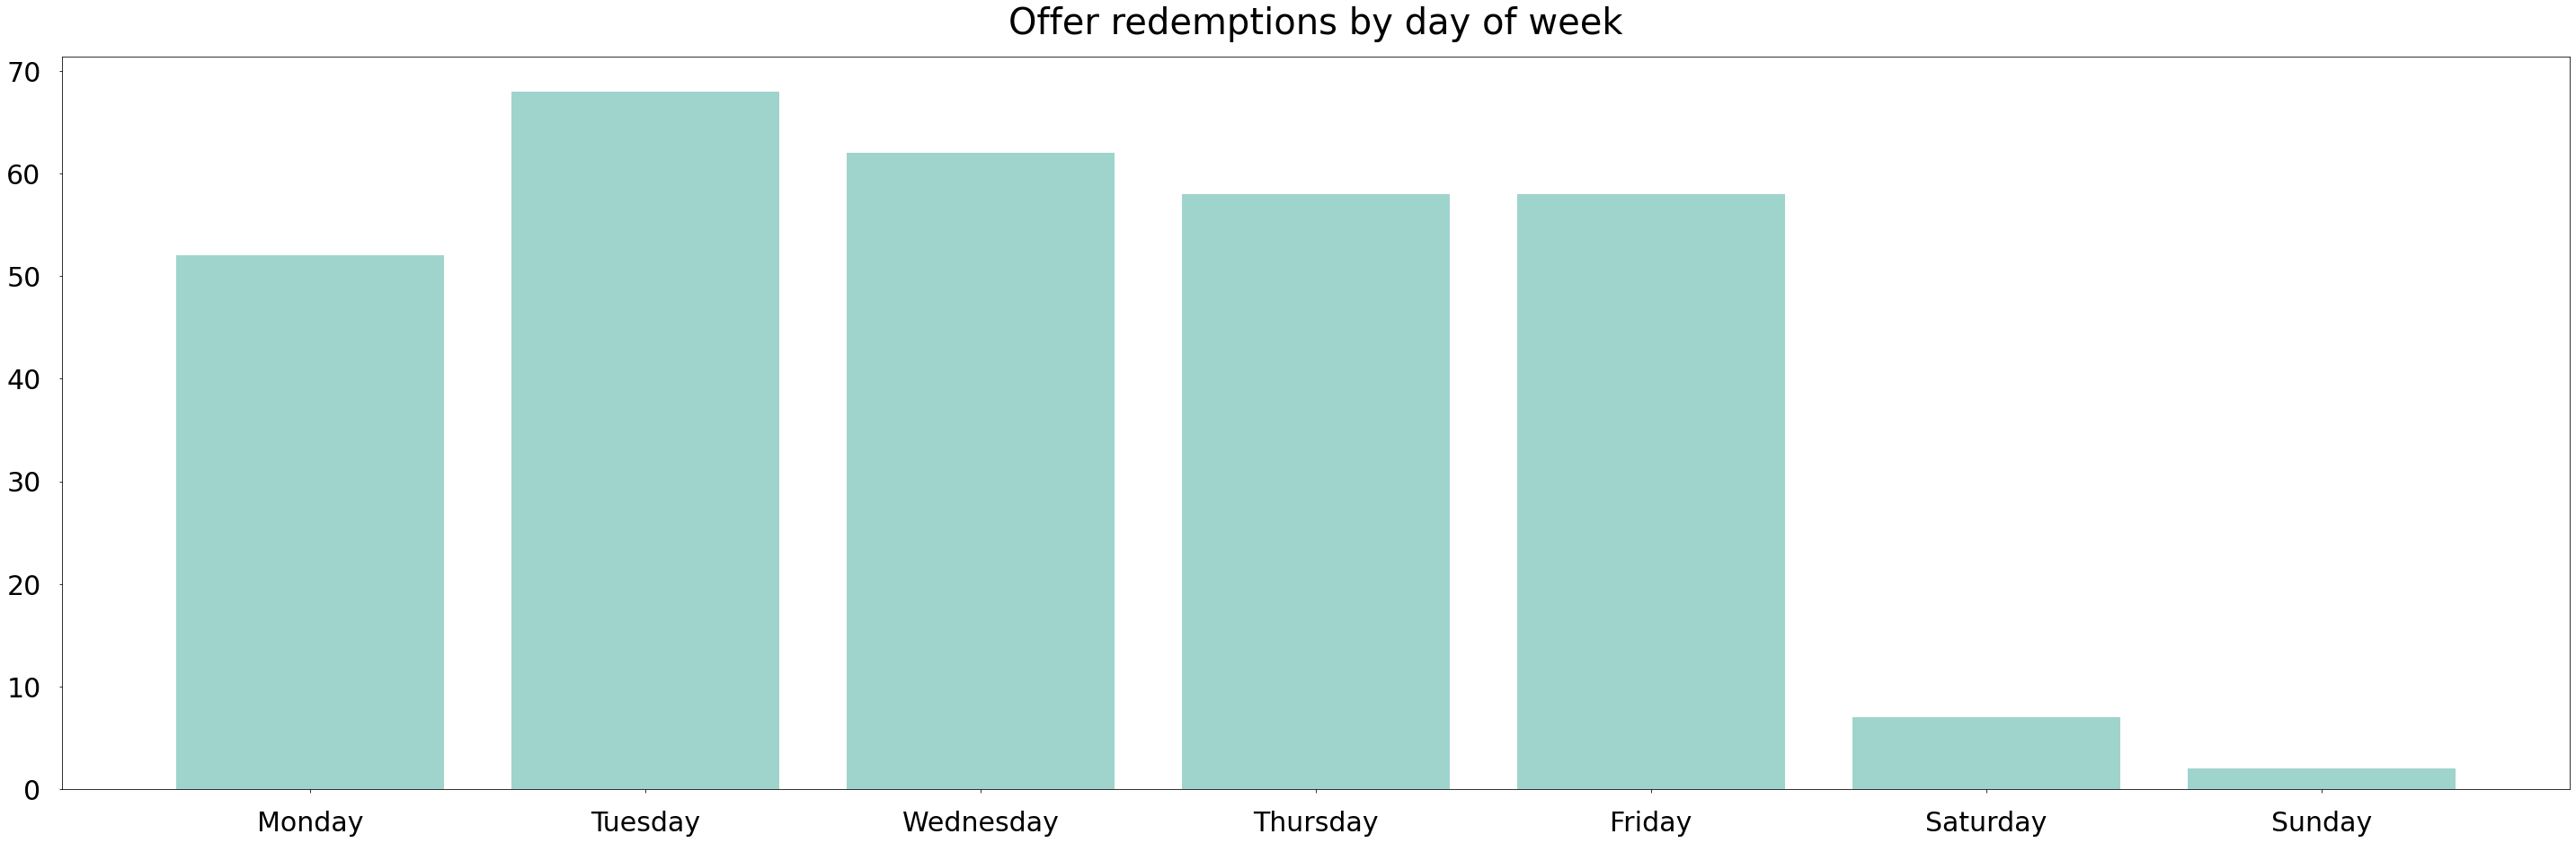

In [772]:
matplotlib.rcParams['xtick.labelsize'] = '30'
matplotlib.rcParams['ytick.labelsize'] = '30'



x = days.index.values
y = days['unique_receipts']
plt.bar(x,y,color = 'mint')
plt.title('Offer redemptions by day of week', size = 40)
plt.show()

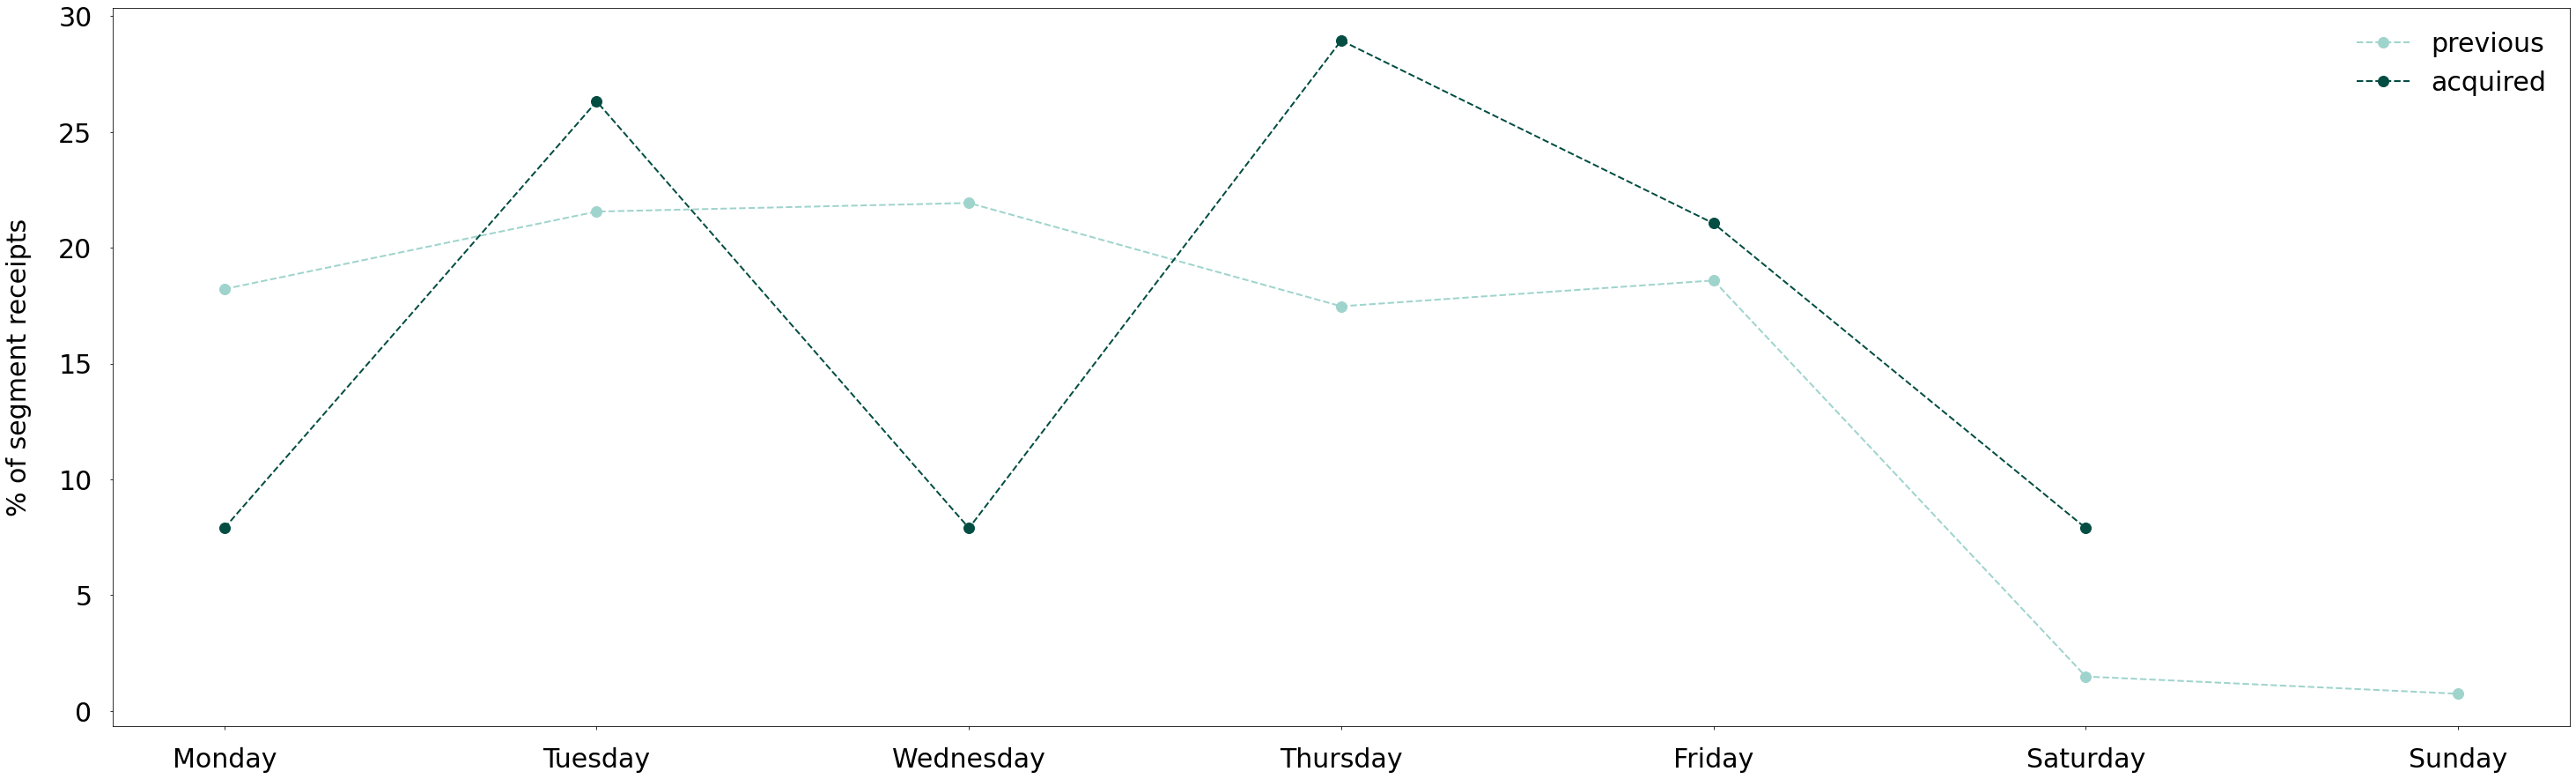

In [777]:
plt.figure()

x1 = days_seg.loc['existing'].index.values
y1 = ((days_seg.loc['existing']/days_seg.loc['existing'].sum())*100)['unique_receipts']
x3 = days_seg.loc['acquired'].index.values
y3 = ((days_seg.loc['acquired']/days_seg.loc['acquired'].sum())*100)['unique_receipts']
plt.plot(x1,y1,color = 'mint', label = 'previous',marker='o', linestyle='dashed',linewidth=2, markersize=12)
plt.plot(x3,y3,color = 'tmnt', label = 'acquired',marker='o', linestyle='dashed',linewidth=2, markersize=12)
#plt.title('Offer redemptions by day of week and segment', size = 40, pad = 10)
plt.legend(fontsize = 30)
plt.ylabel('% of segment receipts', size = 30)
plt.show()

In [221]:
hours = df_during[df_during['redemption_count']>0].groupby(['time_hour']).nunique()['receipt_id']

In [224]:
hours.columns = ['unique_receipts']
top_hour = hours.sort_values(ascending = False).head(1)
print(f'The most popular hour is {top_hour.index.values[0]}')

The most popular hour is 8


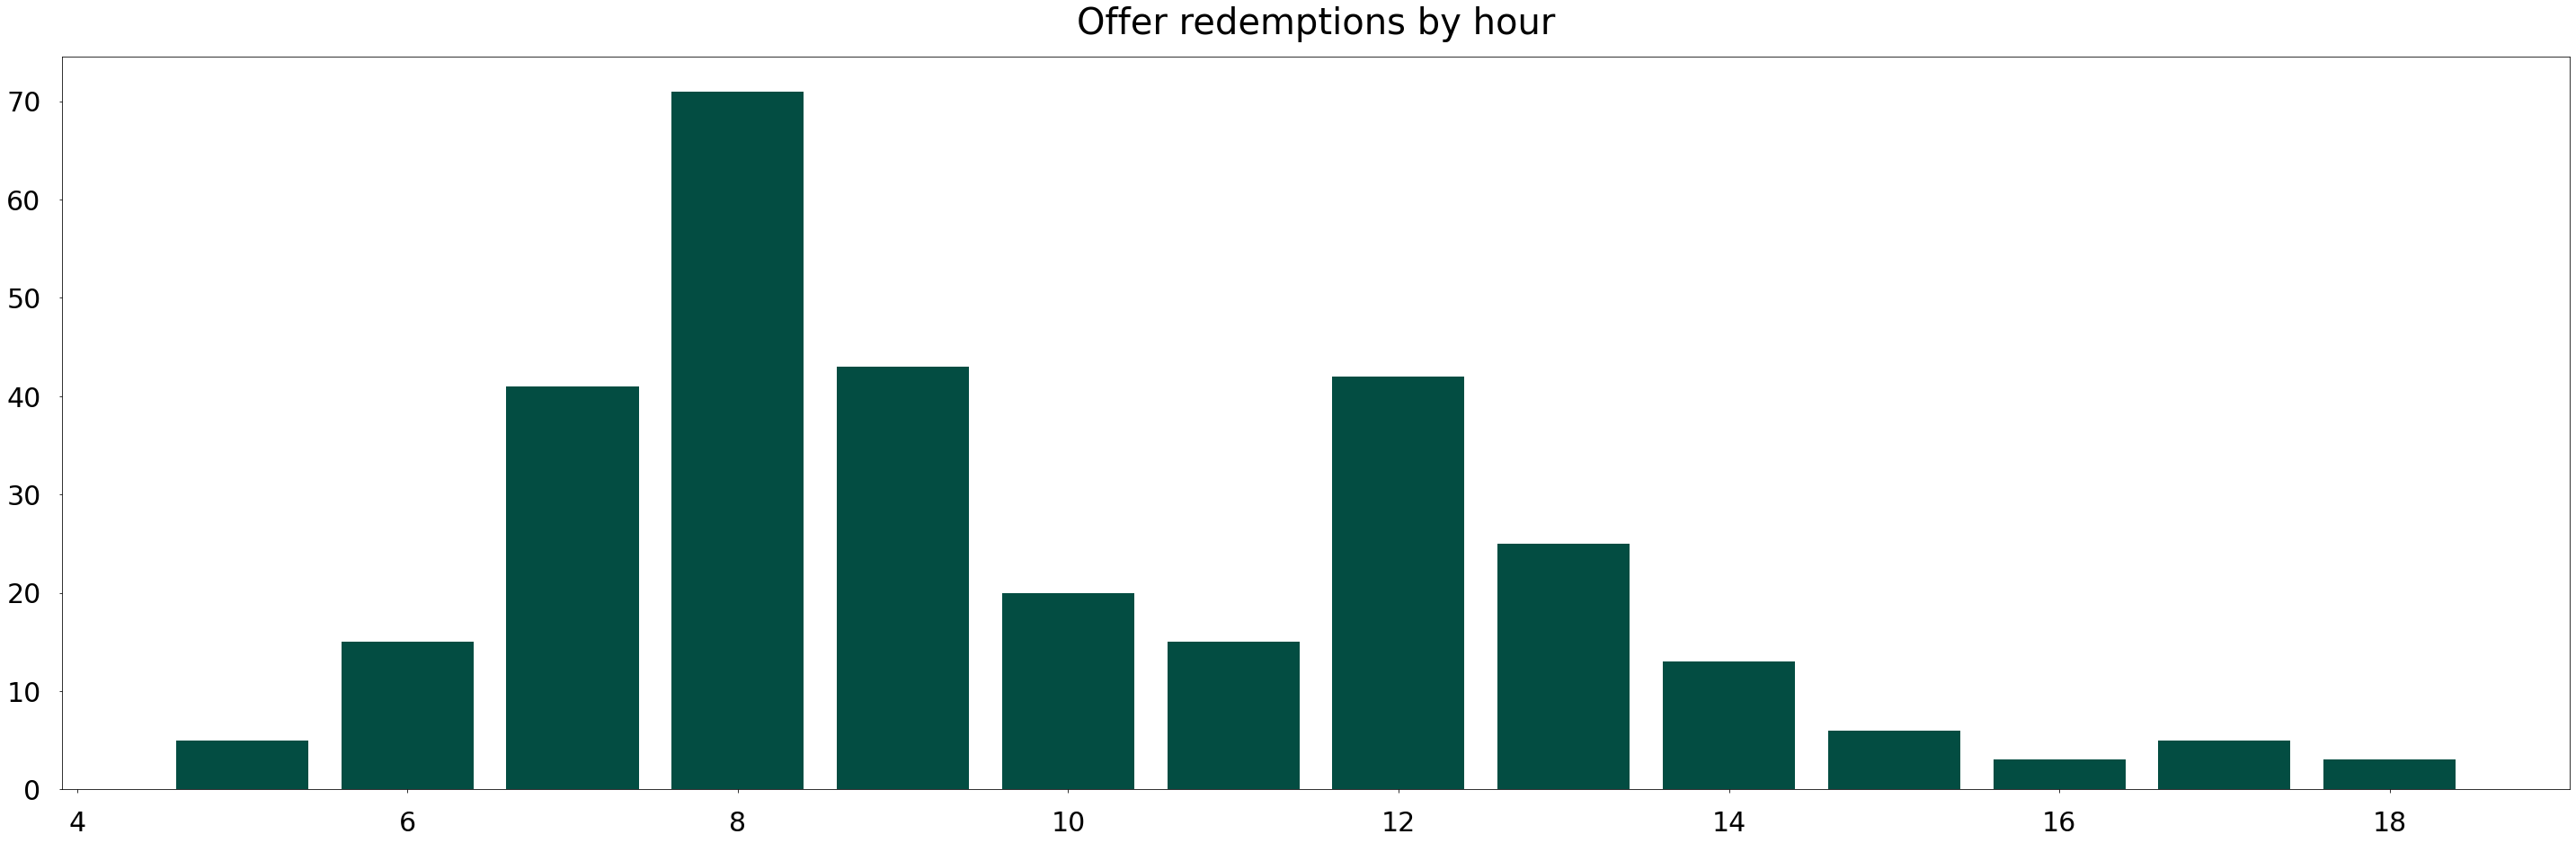

In [230]:
matplotlib.rcParams['xtick.labelsize'] = '30'
matplotlib.rcParams['ytick.labelsize'] = '30'

x = hours.index.values
y = hours
plt.bar(x,y,color = 'tmnt')
plt.title('Offer redemptions by hour', size = 40)
plt.show()

In [779]:
#split by new and existing redeemers
hours_seg = pd.DataFrame(df_during[df_during['redemption_count']>0].groupby(['new_segment','time_hour']).nunique()['receipt_id']).reset_index()
hours_seg['new_segment'] = hours_seg['new_segment'].replace('new','existing')
hours_seg = hours_seg.groupby(['new_segment','time_hour']).sum()
hours_seg.columns = ['unique_receipts']
top_hour_existing = hours_seg.loc['existing'].sort_values(by = 'unique_receipts',ascending = False).head(1).index.values[0]
top_hour_acq = hours_seg.loc['acquired'].sort_values(by = 'unique_receipts',ascending = False).head(1).index.values[0]

print(f'The most popular hour of day for existing customers is {top_hour_existing}')
print(f'The most popular hour of day for new customers is {top_hour_acq}')

The most popular hour of day for existing customers is 8
The most popular hour of day for new customers is 13


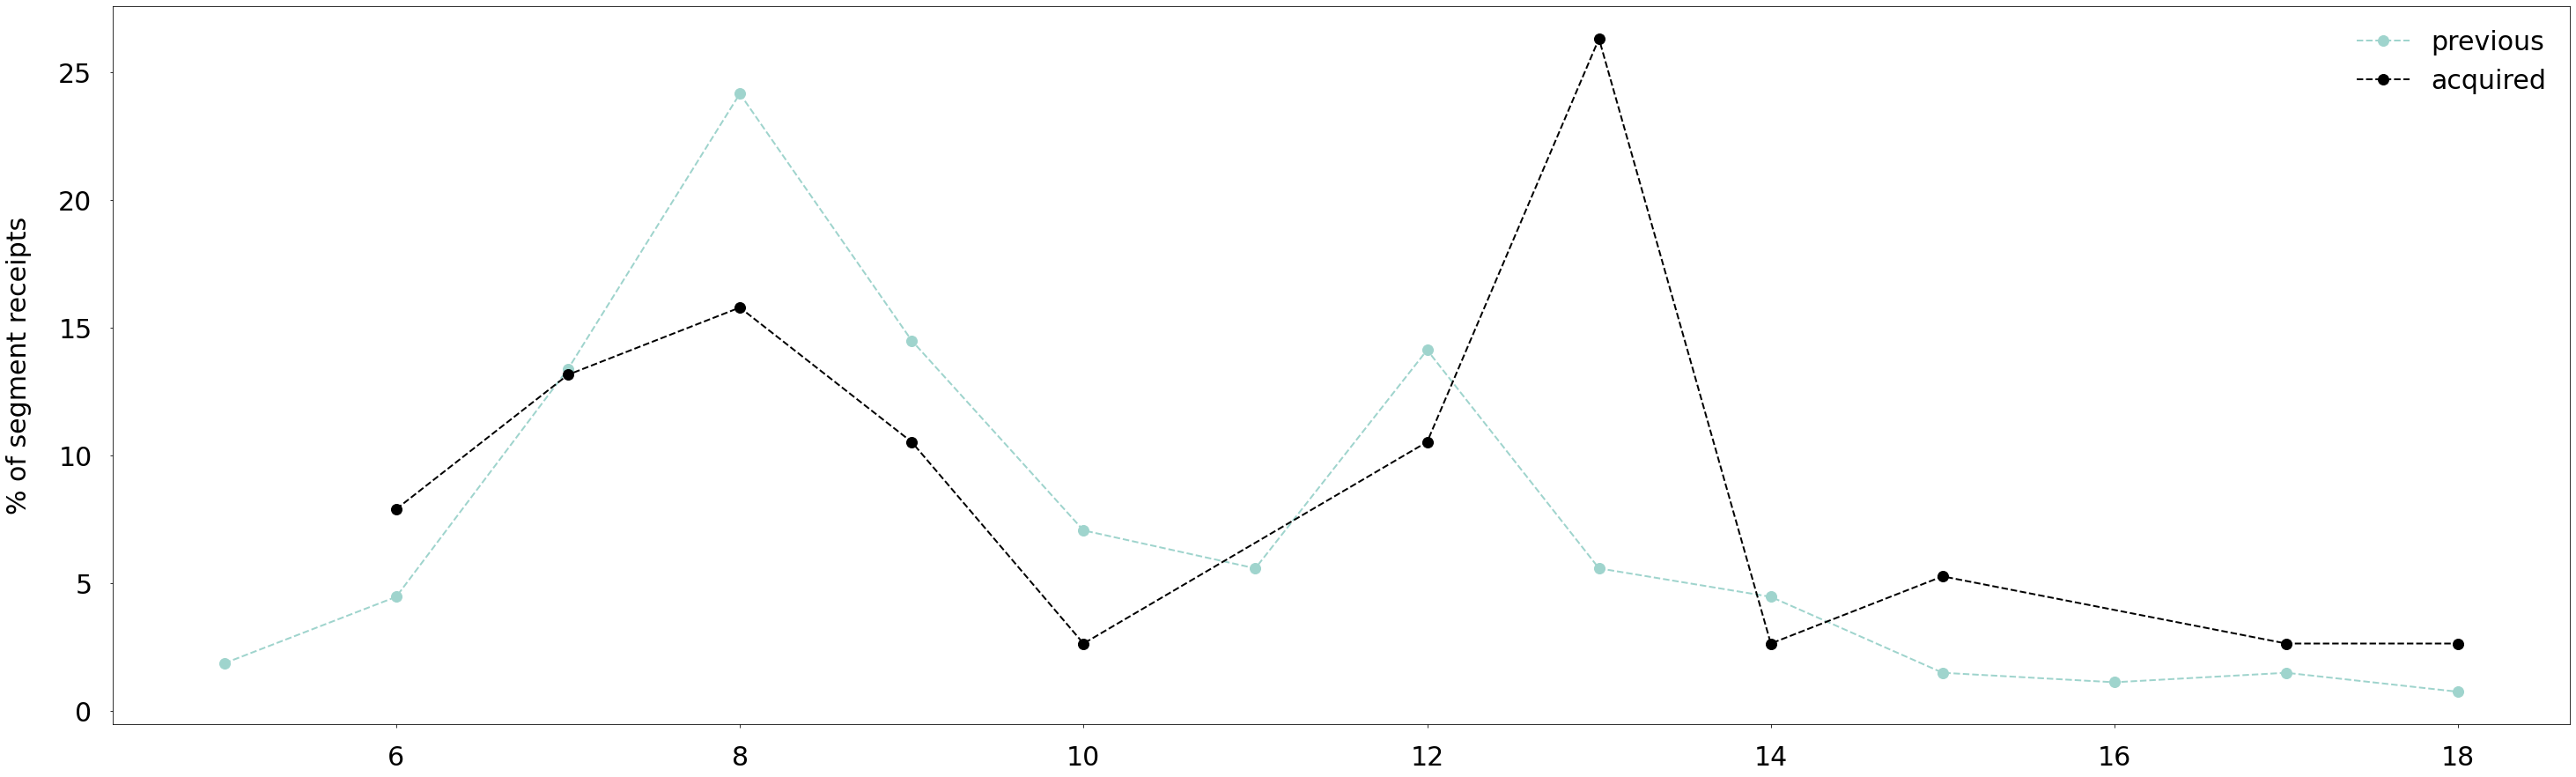

In [782]:
x1 = hours_seg.loc['existing'].index.values
y1 = ((hours_seg.loc['existing']/hours_seg.loc['existing'].sum())*100)['unique_receipts']
x3 = hours_seg.loc['acquired'].index.values
y3 = ((hours_seg.loc['acquired']/hours_seg.loc['acquired'].sum())*100)['unique_receipts']
plt.plot(x1,y1,color = 'mint', label = 'previous',marker='o', linestyle='dashed',linewidth=2, markersize=12)
plt.plot(x3,y3,color = 'black', label = 'acquired',marker='o', linestyle='dashed',linewidth=2, markersize=12)
#plt.title('Offer redemptions by day of week and segment', size = 40, pad = 10)
plt.legend(fontsize = 30)
plt.ylabel('% of segment receipts', size = 30)
plt.show()

In [581]:
#matrix of day and hour

day_hours = pd.DataFrame(df_during[df_during['redemption_count']>0].groupby(['weekday','weekday_name','time_hour']).nunique()['receipt_id'])
day_hours.columns =['unique_receipts']
#day_hours.reset_index('weekday',drop=True,inplace = True)
day_hours_unstack = day_hours.unstack().fillna(0)
day_hours_unstack.reset_index('weekday',drop=True,inplace = True)

In [582]:
day_hours_unstack.style.background_gradient(cmap='BuGn', axis = None).set_precision(0)

## Repeat Redemptions
### Offer Repeat Rate
    - new
    - existing
    - by timeframe (e.g. day, week, month depending on length of offer)

In [583]:
repeat_reds = pd.DataFrame(df_during[df_during.receipt_id.isin(off_receipts)].groupby(['new_segment','customer_id'])['receipt_id'].nunique().reset_index())

In [587]:
repeat_reds.groupby('new_segment').count()

,customer_id,receipt_id
new_segment,,
acquired,22,22
existing,91,91
new,44,44


In [601]:


existing_redeemers = repeat_reds[repeat_reds['new_segment']=='existing']['customer_id'].nunique()
rep_existing_redeemers = repeat_reds[(repeat_reds['new_segment']=='existing') & (repeat_reds['receipt_id']>1)]['customer_id'].nunique()

new_redeemers = repeat_reds[repeat_reds['new_segment']=='new']['customer_id'].nunique()
rep_new_redeemers = repeat_reds[(repeat_reds['new_segment']=='new') & (repeat_reds['receipt_id']>1)]['customer_id'].nunique()

acq_redeemers = repeat_reds[repeat_reds['new_segment']=='acquired']['customer_id'].nunique()
rep_acq_redeemers = repeat_reds[(repeat_reds['new_segment']=='acquired') & (repeat_reds['receipt_id']>1)]['customer_id'].nunique()

pcent_existing = (rep_existing_redeemers/existing_redeemers)*100
pcent_new = (rep_new_redeemers/new_redeemers)*100
pcent_acq = (rep_acq_redeemers/acq_redeemers)*100

print(f'A total of {len(off_receipts)} redemptions were made on the offer')
print('\n')
print(f'The percentage of existing redeemers that made more than 1 redemption is {pcent_existing:.2f}% ({rep_existing_redeemers}/{existing_redeemers})')
print(f'The percentage of new redeemers that made more than 1 redemption is {pcent_new:.2f}% ({rep_new_redeemers}/{new_redeemers})')
print(f'The percentage of acquired redeemers that made more than 1 redemption is {pcent_acq:.2f}% ({rep_acq_redeemers}/{acq_redeemers})')

A total of 307 redemptions were made on the offer


The percentage of existing redeemers that made more than 1 redemption is 37.36% (34/91)
The percentage of new redeemers that made more than 1 redemption is 27.27% (12/44)
The percentage of acquired redeemers that made more than 1 redemption is 27.27% (6/22)


# ***Post offer analysis***:

- Long-term impact on frequency of customers redeeming the offer
    - Time series data
    - vs non-redeemers
- Long term impact of ATV of customers redeeming the offer
    - vs non-redeemers
- Retention of customers who have redeemed the offer vs baseline
- Segment of customers acquired via the offer
    - % in each segment vs expected %

In [606]:
redemption_segment = agg[['offer_segment','customer_id']]
df_red_seg = pd.merge(df,redemption_segment, on = 'customer_id',how = 'left')

In [611]:
df_red_seg['offer_segment'] = df_red_seg['offer_segment'].fillna('non-redeemer')

In [612]:
df_red_seg.head()

,customer_id,account_id,receipt_id,item_id,item_price,updated_date,transaction_date,location_id,total_amount,sku,name,date,day,week,week_start,month,price,offer_segment
0,4f13171e-1a45-46ff-8c14-3112b70ebae0,6b89c002-82af-4fe5-886a-33d5417f7ed8,00c185cd-ec83-4b89-8887-7f1c16d8e027,08cc49fd-5b5f-46d2-9a47-4170be3d8a22,235,2020-08-15 10:55:11.212465+00:00,2020-02-03 09:28:02+00:00,27e2b4b1-6cc3-453e-91d7-a6b530fe8cc6,185.0,6013,Americano White,2020-02-03,1,6,2020-02-03,2,235,non-redeemer
1,9ac48fb9-396b-4cd5-ad90-596c105235f0,d3921b57-954f-47d6-937c-1d8f6abe9d3a,00014237-79d1-427e-b621-c83596340898,0bd6e7f7-33a5-4e23-8fe1-7e4a8851e765,695,2020-08-14 13:37:30.317410+00:00,2019-10-01 11:46:58+00:00,63d55f10-2ab3-47a8-b0bb-63aa6d408ff8,695.0,27007,Thai Red Chicken Curry,2019-10-01,2,40,2019-09-30,10,695,non-redeemer
2,e760b05f-6b53-4059-becf-1de4de50f406,fbf16a96-0117-47a8-a373-1e6aa4ea20e5,0002f7e8-0954-4eb2-9d5a-9f297ea0de7d,686b2ff7-f5b8-4612-8354-b421cd10a655,310,2020-08-14 11:22:54.918136+00:00,2019-08-09 08:35:28+00:00,63d55f10-2ab3-47a8-b0bb-63aa6d408ff8,310.0,55001,AvocadoBacon,2019-08-09,5,32,2019-08-05,8,310,non-redeemer
3,abaf9d05-da3b-4fa4-80a3-ac647d211206,ab04ffbd-8b43-4abf-be0c-87942dfbcd54,00074459-1bbf-4ac2-90c4-45b9e26502b1,19ae6b9b-7943-4180-952f-0b2e74944610,250,2020-08-14 15:38:29.737340+00:00,2019-11-04 08:19:11+00:00,d5c297a2-98ba-458a-b470-00fa491dd1e1,935.0,17003,Banana Honey Yog,2019-11-04,1,45,2019-11-04,11,250,non-redeemer
4,abaf9d05-da3b-4fa4-80a3-ac647d211206,ab04ffbd-8b43-4abf-be0c-87942dfbcd54,00074459-1bbf-4ac2-90c4-45b9e26502b1,a1a339ec-a3fe-44eb-8669-0c390f1c6b17,295,2020-08-14 15:38:29.737340+00:00,2019-11-04 08:19:11+00:00,d5c297a2-98ba-458a-b470-00fa491dd1e1,935.0,6008,Latte,2019-11-04,1,45,2019-11-04,11,295,non-redeemer


In [ ]:
df_red_seg.groupby(['customer_id').